In [1010]:
import matplotlib.pyplot as plt
import pandas as pd

import os
import numpy as np
import time
from scipy.signal import correlate, find_peaks
from collections import defaultdict

In [ ]:
data_path  = r'C:\Users\lhauptmann\Code\WristPPG2\data'
save_dir = r'C:\Users\lhauptmann\Code\WristPPG2\data\dataset'
index = 222
participant_name = "pam_3"

imu_file = f"imu_{index:03d}.txt"
ppg_file = f"ppg_{index:03d}.txt"
label_file = f"labels//label_{index:03d}.csv"

LETTER_GESTURES = {
    "a": "Swipe Forward",
    "b": "Swipe Backward",
    "c": "Swipe Left",
    "d": "Swipe Right",
    "p": "Fast Pinch",
    "prr": "Rotate Right",
    "prl": "Rotate Left",
    "pbd": "Back to Default",
    "pc": "Pinch Hold",
    "po": "Pinch Open",
    "sp": "Side Pinch",
    "o": "Nothing",
    "s": "Knock"
}

sampling_rate_imu = 112.22
sampling_rate_ppg = 112.345

In [1012]:

def read_ppg_csv(data_file, columns = None):
    df = pd.read_csv(data_file, skiprows=32, skipfooter=5, usecols=[0]+list(range(34,69)))
    df["timestamp"] = df["timestamp"]/1000
    df[["ACCX", "ACCY", "ACCZ"]] = df[["ACCX", "ACCY", "ACCZ"]] / 1000
    
    if columns is not None:
        df.rename(columns={col:el for i,(el, col) in enumerate(zip(columns, df.columns))}, inplace=True)
        
    # read all lines in the file
    with open(data_file, "r") as f:
        lines = f.readlines()
    start_time, end_time = None, None    
    for line in lines:
        if line.startswith("start time"):
            start_time = float(line.split(",")[-1])
        if line.startswith("stop_time"):
            end_time = float(line.split(",")[-1])
    
    return df, start_time, end_time

def read_txt_data(data_file, n_features = 9, columns = None, add_package_ids = None, add_package_id_lengths = None):

    data = open(data_file, "r").read()

    rows = data.strip().split("\n")

    def pad_to_longest(package_dict, padding_value=0):
        el_length = sorted(package_dict.items(), key=lambda x: len(x[1]))[::-1]
        longest = len(el_length[0][1])
        shortest = len(el_length[-1][1])
        print(f"Padding by {longest - shortest} elements")

        print(f"Longest element: {el_length[0][0]} with length {longest}")
        print(f"Shortest element: {el_length[-1][0]} with length {shortest}")
        print(f"Second shortest element: {el_length[-2][0]} with length {len(el_length[-2][1])}")
        for k in package_dict.keys():
            package_dict[k] += [padding_value] * (longest - len(package_dict[k]))
        return package_dict

    def update_dict(data_dict, package_dict, package_id=None):
        longest_package_length = min([len(v) for v in package_dict.values()])
        if package_id is not None:
            package_dict["package_id"] = [package_id] * longest_package_length
        
        for k in package_dict.keys():
            data_dict[k].extend(package_dict[k])
        return data_dict


    data_dict = {k:[] for k in range(0,n_features)}
    data_dict["package_id"] = []
    package_dict = {k:[] for k in range(0,n_features)}
    # Loop over each row
    package_id = 0
    previous_key = 100
    start_time = 0
    end_time = 0
    for row in rows:
        if row.startswith('start time'):
            start_time = float(row.split(":")[-1])
            continue
        if row.startswith('end time'):
            end_time = float(row.split(":")[-1])
            continue
        # Split the row by spaces and convert each entry to an integer
        row_split = row.split(" ")
        key = int(row_split[0])  
        data_values = [float(el) for el in row_split[1:] if el != ""]
        if key < previous_key: # next package
            #package_dict = pad_to_longest(package_dict, padding_value=np.nan)
            data_dict = update_dict(data_dict, package_dict, package_id)
            
            package_id += 1
            if add_package_ids:
                for add_package_id,add_package_id_length in zip(add_package_ids, add_package_id_lengths):
                    if add_package_id == package_id:
                        # adds and empty package at this point
                        empty_package_length = add_package_id_length if add_package_id_length else len(package_dict[0])
                        empty_package_dict = {k:[np.nan] * empty_package_length for k in range(0,n_features)}
                        data_dict = update_dict(data_dict, empty_package_dict, package_id)
                        package_id += 1
            
            package_dict = {k:[] for k in range(0,n_features)}
                
            
        package_dict[key].extend(data_values)
        previous_key = key
    #return None, start_time, end_time, data_dict, package_dict
    data_dict = pad_to_longest(data_dict, padding_value=np.nan)
    
    df_data = pd.DataFrame(data_dict)
    if columns is not None:
        df_data.rename(columns={i:el for i,el in enumerate(columns)}, inplace=True)
    return df_data, start_time, end_time, data_dict


In [1013]:
ppg_columns = ["ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8",
               "ppg_ir_1", "ppg_ir_2","ppg_ir_3", "ppg_ir_4","ppg_ir_5", "ppg_ir_6","ppg_ir_7", "ppg_ir_8", 
               #"ppg_red_1", "ppg_red_2","ppg_red_3", "ppg_red_4","ppg_red_5", "ppg_red_6","ppg_red_7", "ppg_red_8", 
               #"ppg_amb_1", "ppg_amb_2","ppg_amb_3", "ppg_amb_4","ppg_amb_5", "ppg_amb_6","ppg_amb_7", "ppg_amb_8", 
               "acc_ppg_x", "acc_ppg_y", "acc_ppg_z", 
               "timestamp"
               ]

add_package_id, add_package_id_length = None, None
if index == 87:
    add_package_id = [32, 149, 52]
    add_package_id_length = [245, 20, 10]
elif index == 89:
    add_package_id = [70]
    add_package_id_length = [60]
elif index == 46:
    add_package_id = [22, 47, 65]
    add_package_id_length = [250, 250, 22]
elif index == 71:
    add_package_id = [77, 101, 113, 123]
    add_package_id_length = [35, 20, 55, 10]
elif index == 40:
    add_package_id = [42,47]
    add_package_id_length = [28, 17]
elif index == 162:
    add_package_id = [125, 129]
    add_package_id_length = [130, 125]
elif index == 163:
    add_package_id = [96, 101]
    add_package_id_length = [125, 125]
elif index == 171:
    add_package_id = [75, 77, 80, 81, 90, 103]
    add_package_id_length = [120, 1, 20, 235, 130, 125]
elif index == 175:
    add_package_id = [76]
    add_package_id_length = [130]
elif index == 184:
    add_package_id = [41, 64, 69, 73, 76, 79, 82, 85, 90, 95, 102, 116, 123]
    add_package_id_length = [128, 125, 125, 130, 130, 130, 130, 130, 130, 125, 125, 125, 125]
elif index == 185:
    add_package_id = []
    add_package_id_length = []
elif index == 188:
    add_package_id = [177]
    add_package_id_length = [126]
elif index == 190:
    add_package_id = [37, 45, 53, 64, 70, 82, 93, 108, 126, 132, 158]
    add_package_id_length = [123, 123, 123, 123, 123, 123, 123, 123, 122, 125, 123]


df_ppg, ppg_start, ppg_end, ppg_dict = read_txt_data(os.path.join(data_path, ppg_file), n_features=len(ppg_columns), columns = ppg_columns, add_package_ids=add_package_id, add_package_id_lengths=add_package_id_length)

ppg_acc_factor = 4 if (index < 8 and index != 3) else 1
df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] = df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] * ppg_acc_factor



#print(f"Time of Recording: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(ppg_start))}")

Padding by 284 elements
Longest element: 19 with length 40488
Shortest element: package_id with length 40204
Second shortest element: 8 with length 40486


In [1014]:
imu_columns = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "timestamp", "timestamp_computer"]

df_imu, imu_start, imu_end, imu_dict = read_txt_data(os.path.join(data_path, imu_file), n_features=8, columns = imu_columns)

Padding by 4 elements
Longest element: 7 with length 40814
Shortest element: package_id with length 40810
Second shortest element: 0 with length 40814


In [1015]:

#df_ppg.dropna(inplace=True)

if df_imu["timestamp"].duplicated().any():
    n_duplicates = df_imu["timestamp"].duplicated().sum()
    print(f"Found {n_duplicates} duplicates in the imu data")
    df_imu.drop_duplicates(subset="timestamp", inplace=True)
df_imu.dropna(subset=["timestamp"], inplace=True)
df_imu.set_index("timestamp", inplace=True)
df_imu.interpolate(inplace=True, method="slinear")
df_imu.reset_index(inplace=True)

if index == 60:
    outlier_index = df_imu["timestamp"].diff().idxmin()
    df_imu.loc[outlier_index,"timestamp"] = pd.NA
    df_imu["timestamp"] = df_imu["timestamp"].interpolate()
# setting the imu timestamp to match the ppg timestamp

if index in [123, 124, 125, 126]:
    df_imu_new = df_imu.copy()
    df_imu_new["acc_x"] = -df_imu["acc_y"]
    df_imu_new["acc_y"] = -df_imu["acc_x"]
    df_imu_new["acc_z"] = -df_imu["acc_z"]
    df_imu_new["gyro_x"] = -df_imu["gyro_y"]
    df_imu_new["gyro_y"] = -df_imu["gyro_x"]
    df_imu_new["gyro_z"] = -df_imu["gyro_z"]
    df_imu = df_imu_new

if index == 100: # funny jumps in the imu timestamp
    df_imu = df_imu[df_imu["timestamp"] >= df_imu["timestamp"].mean()]


if (df_imu["timestamp"].diff() < -1000).any(): # most likely overflow in timestamp counter
    
    jump = df_imu["timestamp"].diff().idxmin()
    df_imu.loc[jump:,"timestamp"] = df_imu.loc[jump:,"timestamp"] + 2**24


df_imu["timestamp"] = (df_imu["timestamp"] - df_imu["timestamp"].iloc[0])/1000 + imu_start

#df_imu["timestamp"].diff().hist(bins=100, log=True)


In [1016]:
labels = pd.read_csv(os.path.join(data_path, label_file))

In [1017]:
current_package_timestamp = ppg_start
current_timestamp = ppg_start



df_ppg["package_id"] = df_ppg["package_id"].ffill()
df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])] = df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])].rolling(window=3).median()
df_ppg.interpolate(inplace=True)


In [1018]:
def mean_acc_corr(df_ppg, df_imu):
    # best is 112.3 Hz for sampling_rate_ppg
    
    calibration_peaks_imu = find_peaks(df_imu["acc_z"] - df_imu["acc_z"].mean(), height=10, prominence=3, distance=100)
    calibration_peaks_ppg = find_peaks(df_ppg["acc_ppg_z"] - df_ppg["acc_ppg_z"].mean(), height=10, prominence=3, distance=100)
    #print(calibration_peaks_imu)
    #print(calibration_peaks_ppg)

    imu_peak_index = 0
    ppg_peak_index = 0

    time_offset = df_ppg["timestamp"].iloc[calibration_peaks_ppg[0][ppg_peak_index]] - df_imu["timestamp"].iloc[calibration_peaks_imu[0][imu_peak_index]]
    df_ppg["timestamp"] = df_ppg["timestamp"] - time_offset
    
    df_imu_re = df_imu.dropna(inplace=False, subset="timestamp")
    df_imu_re = df_imu_re.set_index("timestamp")
    df_ppg_re = df_ppg.dropna(inplace=False, subset="timestamp")
    df_ppg_re = df_ppg.set_index("timestamp")
    df_imu_re = df_imu_re.reindex(df_imu_re.index.union(df_ppg_re.index))
    df_imu_re.interpolate(method='slinear', inplace=True, assume_sorted=False)
    df_imu_re = df_imu_re.reindex(df_ppg_re.index).dropna()
    df_ppg_re = df_ppg_re.reindex(df_imu_re.index)
    
    #ax = df_ppg_re["acc_ppg_x"].plot()
    #df_imu_re["acc_x"].plot(ax=ax)
    
    return np.mean([df_ppg_re["acc_ppg_z"].corr(df_imu_re["acc_z"]), df_ppg_re["acc_ppg_x"].corr(df_imu_re["acc_x"]), df_ppg_re["acc_ppg_y"].corr(df_imu_re["acc_y"])])



In [1019]:
## setting the ppg timestamp based| on the package ids , every package is every 2 seconds
#current_package_timestamp = ppg_start
#current_timestamp = ppg_start
#
#df_ppg["timestamp"] = 0
#current_package_id = df_ppg["package_id"].iloc[0]
#for i, row in df_ppg.iterrows():
#    if row["package_id"] != current_package_id:
#        current_package_id = row["package_id"]
#        current_package_timestamp += 2.005#2.004 # should be 2, but empirically found to be 2.004
#        current_timestamp = current_package_timestamp
#    else:
#        current_timestamp += 1/sampling_rate
#    df_ppg.at[i, "timestamp"] = current_timestamp
#    
##while (df_ppg["timestamp"].diff() < 0).any():
#    df_ppg = df_ppg[df_ppg["timestamp"].diff() >= 0]



In [1020]:
result_dict = {}
for sampling_rate_ppg in np.linspace(112.1, 112.4, 30):

    current_package_timestamp = ppg_start
    current_timestamp = ppg_start

    df_ppg["timestamp"] = np.arange(ppg_start, ppg_start + 1/sampling_rate_ppg*(len(df_ppg) - 0.1), 1/sampling_rate_ppg)

    result_dict[sampling_rate_ppg] = mean_acc_corr(df_ppg, df_imu)
    
pd.Series(result_dict).sort_values(ascending=False)
sampling_rate_ppg = pd.Series(result_dict).idxmax()
print(f"Best sampling rate for PPG is {sampling_rate_ppg} with correlation {pd.Series(result_dict).max()}")

if index == 89:
    sampling_rate_ppg += 0.05

if index == 50:
    sampling_rate_ppg += 0.05
    
if index == 59:
    sampling_rate_ppg += 0.025
    
if index == 146:
    sampling_rate_ppg -= 0.05

    

Best sampling rate for PPG is 112.27586206896552 with correlation 0.9847324637626262


In [1021]:

df_ppg["timestamp"] = np.arange(ppg_start, ppg_start + 1/sampling_rate_ppg*(len(df_ppg) - 0.1), 1/sampling_rate_ppg)
df_ppg["package_id"] = df_ppg["package_id"].ffill()
df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])] = df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])].rolling(window=3).median()
df_ppg.interpolate(inplace=True)



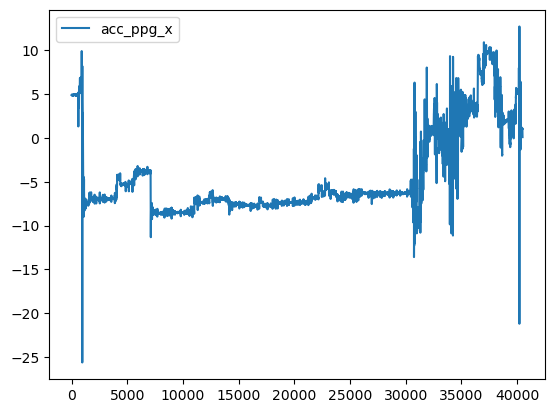

In [1022]:
# plot where the nans are
ax = df_ppg.plot(y="acc_ppg_x")
#df_ppg[df_ppg["acc_ppg_x"].isna()].plot(x="timestamp", y="acc_ppg_x", ax=ax, style="o")

In [1023]:
# looking for calibration peaks to match the data


calibration_peaks_imu = find_peaks(df_imu["acc_z"] - df_imu["acc_z"].mean(), height=10, prominence=3, distance=100)
calibration_peaks_ppg = find_peaks(df_ppg["acc_ppg_z"] - df_ppg["acc_ppg_z"].mean(), height=10, prominence=3, distance=100)
print(calibration_peaks_imu)
print(calibration_peaks_ppg)



(array([ 1152, 31634, 31957, 32087, 32771, 32921, 33314, 33414, 33589,
       33710, 33852, 33965, 34137, 34307, 34407, 34605, 34834, 38469,
       38806, 40002, 40345, 40664, 40772], dtype=int64), {'peak_heights': array([17.89015164, 10.18597256, 10.67814907, 10.76915981, 12.34208889,
       10.90687344, 11.22361477, 15.01792446, 10.23507046, 10.30692105,
       13.06059475, 12.97856533, 14.12098965, 13.03365078, 15.7951083 ,
       15.18976711, 17.89015164, 17.89015164, 11.06674099, 11.34037197,
       17.89015164, 17.89015164, 17.89015164]), 'prominences': array([22.08866638, 12.38284973,  7.67484009,  6.58271118,  9.02622986,
        5.96898743,  6.37973328, 13.98032776,  7.48383728,  7.69938904,
       10.78058167, 11.03984253, 12.6792334 , 10.45545776, 15.69935303,
       13.37378906, 28.2833844 , 28.2833844 , 10.13272888, 19.99062927,
       20.97318604, 20.91630432, 18.66259094]), 'left_bases': array([   45, 30927, 30927, 30927, 30927, 32778, 32941, 30927, 33544,
       33690, 

In [1024]:
imu_peak_index = 0
ppg_peak_index = 0

time_offset = df_ppg["timestamp"].iloc[calibration_peaks_ppg[0][ppg_peak_index]] - df_imu["timestamp"].iloc[calibration_peaks_imu[0][imu_peak_index]]
print(time_offset)

df_ppg["timestamp"] = df_ppg["timestamp"] - time_offset

-1.7424743175506592


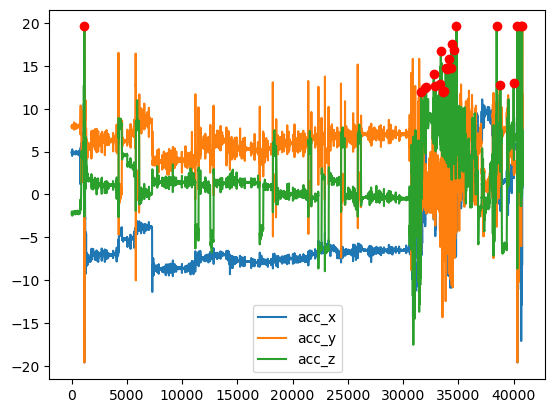

In [1025]:
ax = df_imu.plot( y=["acc_x", "acc_y", "acc_z"])
ax.plot(df_imu.iloc[calibration_peaks_imu[0]]["acc_z"], "ro")

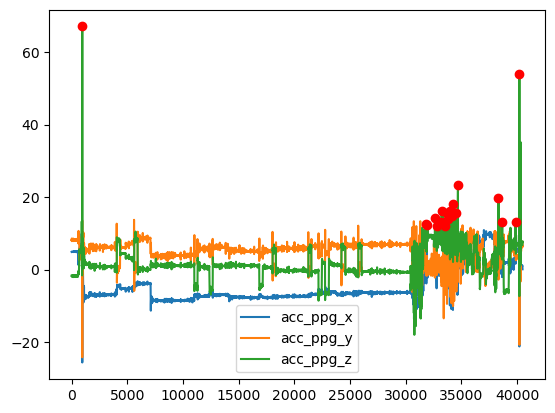

In [1026]:

ax = df_ppg.plot(y=["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"])
ax.plot(df_ppg.iloc[calibration_peaks_ppg[0]]["acc_ppg_z"], "ro")

In [1027]:
from scipy import signal

def resample_df(df, old_freq, new_freq, timestamp_col="timestamp"):
    """
    Resample the dataframe based on the given old and new frequency.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data to resample, with a timestamp column.
        timestamp_col (str): Name of the column containing timestamps.
        old_freq (float): Original sampling frequency in Hz.
        new_freq (float): Desired new sampling frequency in Hz.
        
    Returns:
        pd.DataFrame: Resampled DataFrame.
    """
    # Sort by timestamp to ensure order
    
    df = df.sort_values(by=timestamp_col).reset_index(drop=True)
    
    # Calculate the number of samples for the new frequency
    num_samples = int(len(df) * (new_freq / old_freq))
    
    # Generate a new time axis for resampling
    old_time = np.linspace(0, len(df) / old_freq, len(df))
    new_time = np.linspace(df[timestamp_col].iloc[0], df[timestamp_col].iloc[0] + len(df)  / old_freq, num_samples)
    
    # Resample each column except timestamp using scipy's resample
    resampled_data = {timestamp_col: new_time}
    for col in df.columns:
        if col != timestamp_col:
            resampled_data[col] = signal.resample(df[col].values, num_samples)
    
    return pd.DataFrame(resampled_data)


imu_resampled = resample_df(df_imu, sampling_rate_imu, sampling_rate_ppg)

<Axes: xlabel='timestamp'>

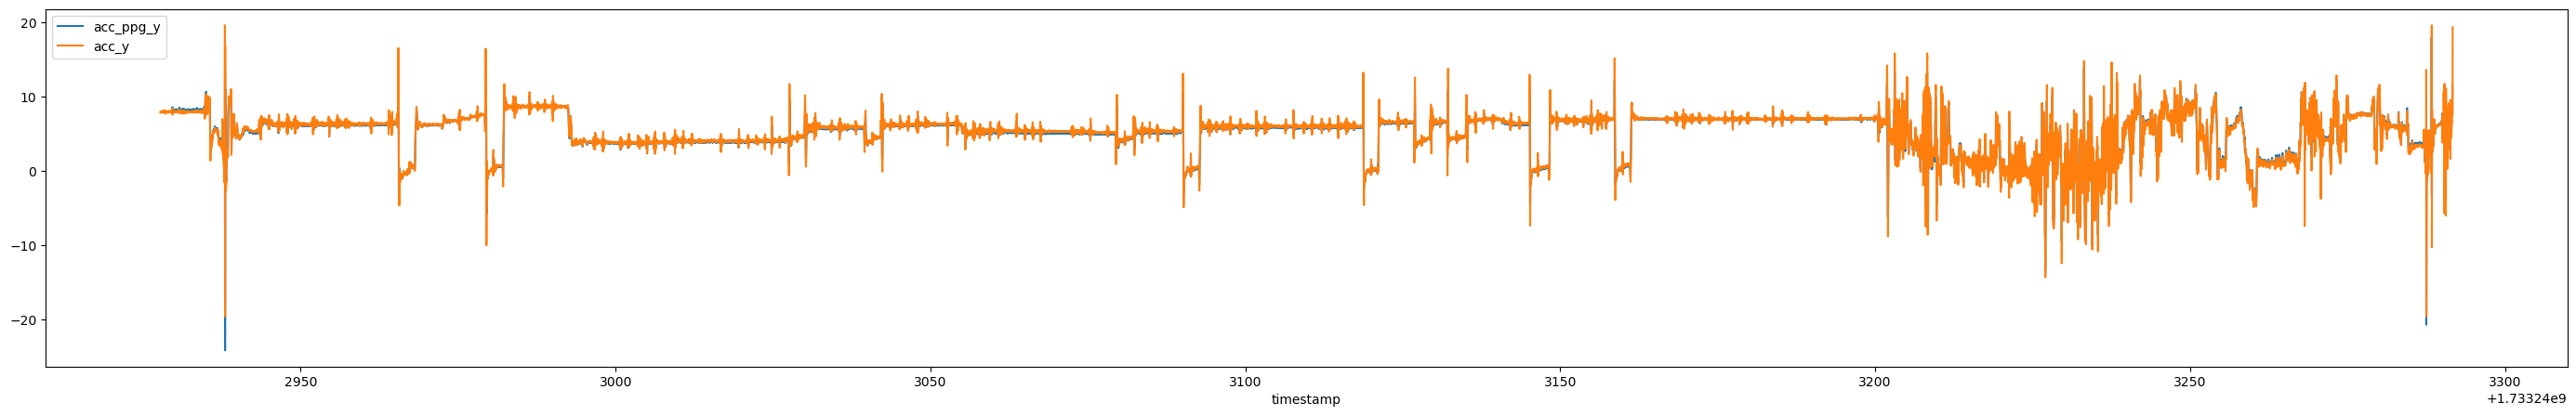

In [1028]:
fig, ax = plt.subplots(1, figsize=(35,5))
df_ppg.plot( y=["acc_ppg_y"], x="timestamp", ax=ax)

df_imu.plot( y=["acc_y"], x="timestamp",  ax=ax)

<Axes: xlabel='timestamp'>

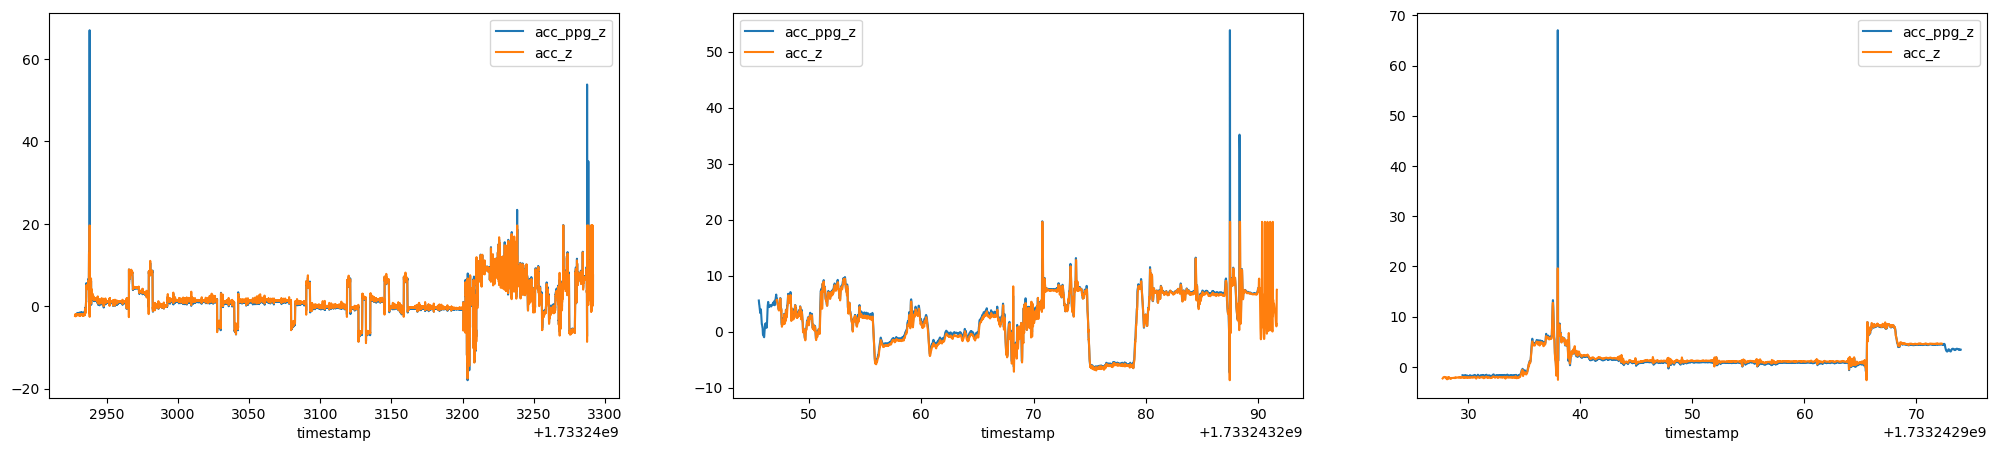

In [1029]:
fig, axes = plt.subplots(1,3, figsize=(25,5))
df_ppg.plot( y=["acc_ppg_z"], x = "timestamp", ax=axes[0])
df_imu.plot( y=["acc_z"], x = "timestamp", ax=axes[0])

df_ppg.iloc[:5000].plot(y=["acc_ppg_z"], x = "timestamp", ax=axes[2])
df_imu.iloc[:5000].plot(y=["acc_z"], x = "timestamp", ax=axes[2])
df_ppg.iloc[-5000:].plot(y=["acc_ppg_z"], x = "timestamp", ax=axes[1])
df_imu.iloc[-5000:].plot(y=["acc_z"], x = "timestamp", ax=axes[1])



In [1030]:
df_ppg.set_index("timestamp", inplace=True)
df_imu.dropna(inplace=True, subset="timestamp")
df_imu.set_index("timestamp", inplace=True)

In [1031]:
df_imu_re = df_imu.reindex(df_imu.index.union(df_ppg.index))
df_imu_re.interpolate(method='slinear', inplace=True, assume_sorted=False)
df_imu_re = df_imu_re.reindex(df_ppg.index).dropna()
df_ppg_re = df_ppg.reindex(df_imu_re.index)

In [1032]:
imu_mag = np.sqrt(df_imu_re["acc_z"]**2 + df_imu_re["acc_y"]**2 + df_imu_re["acc_x"]**2)
ppg_mag = np.sqrt(df_ppg_re["acc_ppg_z"]**2 + df_ppg_re["acc_ppg_y"]**2 + df_ppg_re["acc_ppg_x"]**2)
calibration_peaks_imu = find_peaks((imu_mag - imu_mag.mean()).abs(), height=5, prominence=6, distance=80)[0]
calibration_peaks_ppg = find_peaks((ppg_mag - ppg_mag.mean()).abs(), height=5, prominence=6, distance=80)[0]
calibration_peaks_ppg, calibration_peaks_imu

(array([  959, 30773, 30910, 31306, 33262, 33411, 33702, 33986, 34100,
        34204, 34353, 34455, 34593, 34684, 38325, 39859, 40202, 40298],
       dtype=int64),
 array([  958,  4050,  5606, 22172, 22763, 25732, 30774, 30910, 31307,
        33264, 33412, 33703, 33993, 34101, 34205, 34307, 34456, 34594,
        34685, 38326, 40204, 40299], dtype=int64))

[  959 30773 30910 31306 33262 33411 33702 33986 34100 34204 34353 34455
 34593 34684 38325 39859 40202 40298] timestamp
1.733243e+09    67.023291
1.733243e+09   -17.977832
1.733243e+09   -15.561328
1.733243e+09   -13.199854
1.733243e+09    15.994385
1.733243e+09    10.611084
1.733243e+09    15.542188
1.733243e+09    16.118799
1.733243e+09     9.601416
1.733243e+09    16.614063
1.733243e+09    16.118799
1.733243e+09    14.900977
1.733243e+09    13.415186
1.733243e+09    23.399414
1.733243e+09    19.717236
1.733243e+09    13.223779
1.733243e+09    53.837793
1.733243e+09    35.187646
Name: acc_ppg_z, dtype: float64


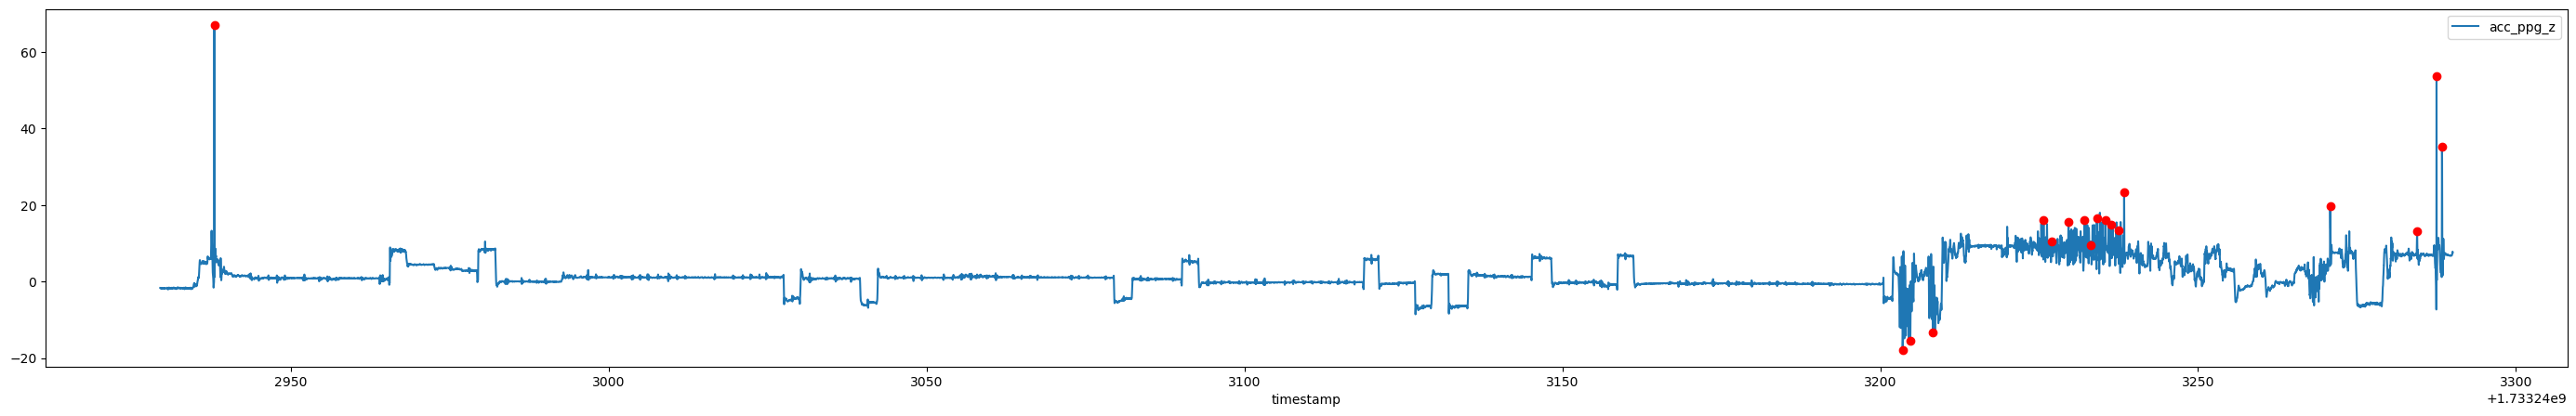

In [1033]:
# plot acc_ppg_z with peaks
fig, ax = plt.subplots(1, figsize=(35,5))
df_ppg_re.plot(y=["acc_ppg_z"], ax=ax)

ax.plot(df_ppg_re.iloc[calibration_peaks_ppg]["acc_ppg_z"], "ro")
print(calibration_peaks_ppg, df_ppg_re.iloc[calibration_peaks_ppg]["acc_ppg_z"])

In [1038]:
start_peak_id = 0
end_peak_id = -2
align_with = [
            'start', 
            'end'
              ]

In [1039]:
ppg_length = df_ppg_re.iloc[calibration_peaks_ppg[start_peak_id]].name - df_ppg_re.iloc[calibration_peaks_ppg[end_peak_id]].name
label_length = labels[labels["label"] == "s"]["start_time"].diff().iloc[-1]
ppg_length, label_length

(-349.52181601524353, 349.63467836380005)

In [1040]:
labels_calibration_start_time = labels[labels["label"] == "s"].iloc[0]["start_time"]
labels_calibration_end_time = labels[labels["label"] == "s"].iloc[-1]["start_time"]
time_diff = []
if 'start' in align_with:
    time_diff.append(df_ppg_re.iloc[calibration_peaks_ppg[start_peak_id]].name - labels_calibration_start_time)
if 'end' in align_with:
    time_diff.append(df_ppg_re.iloc[calibration_peaks_ppg[end_peak_id]].name - labels_calibration_end_time)
print(time_diff)
time_diff = np.mean(time_diff)

labels_re = labels.copy()
labels_re[["start_time", "end_time"]] = labels[["start_time", "end_time"]] + time_diff


if index <= 12 and not index == 8 and not index ==3:

    for i, row in labels_re.iterrows():
        if row["label"] == "s":
            continue
        previous_end_time = labels_re.iloc[i-1]["end_time"]
        start_time = max(row["start_time"] - 1.4, previous_end_time+0.1)
        labels_re.at[i, "start_time"] = start_time

[3.288867950439453, 3.1760056018829346]


In [1041]:
df_all = pd.concat([df_imu_re, df_ppg_re], axis=1)

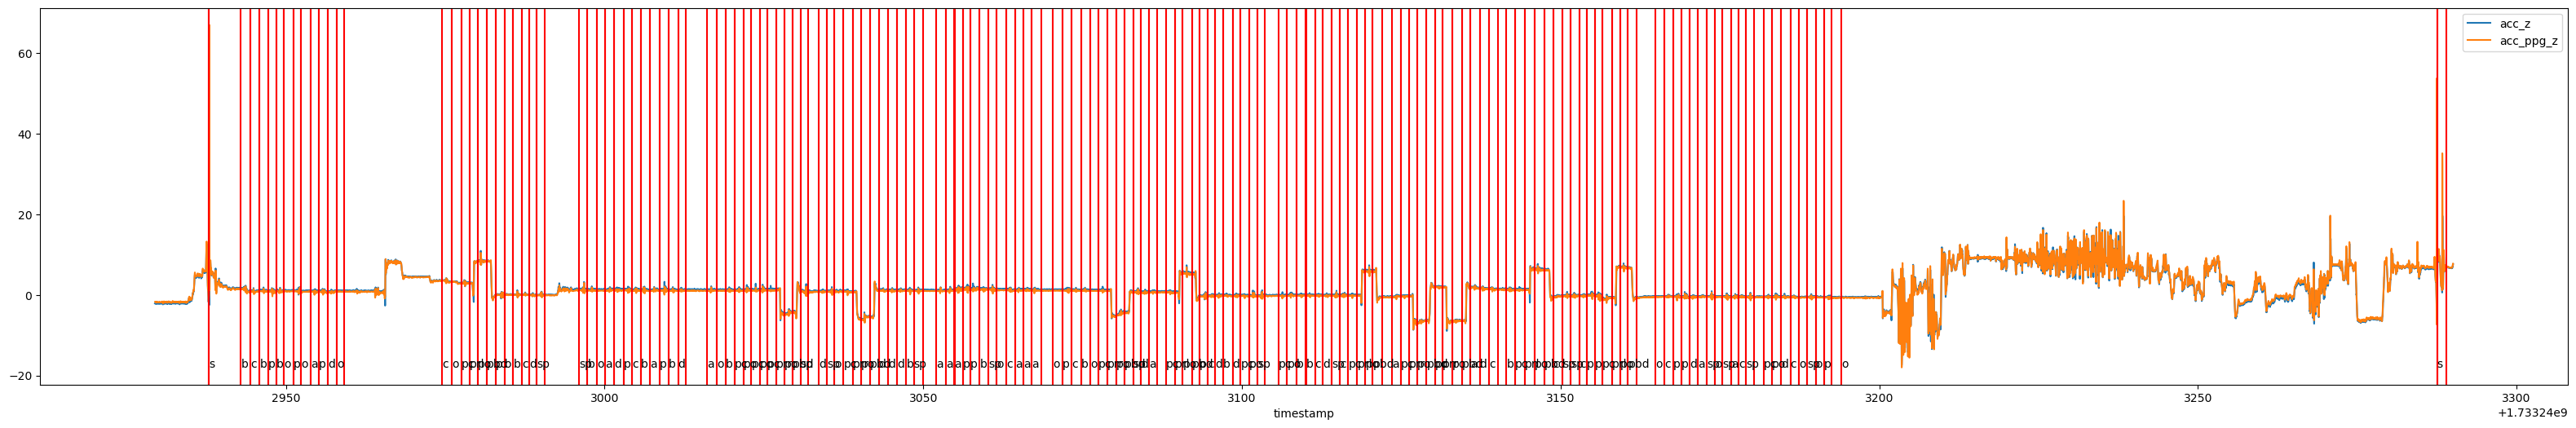

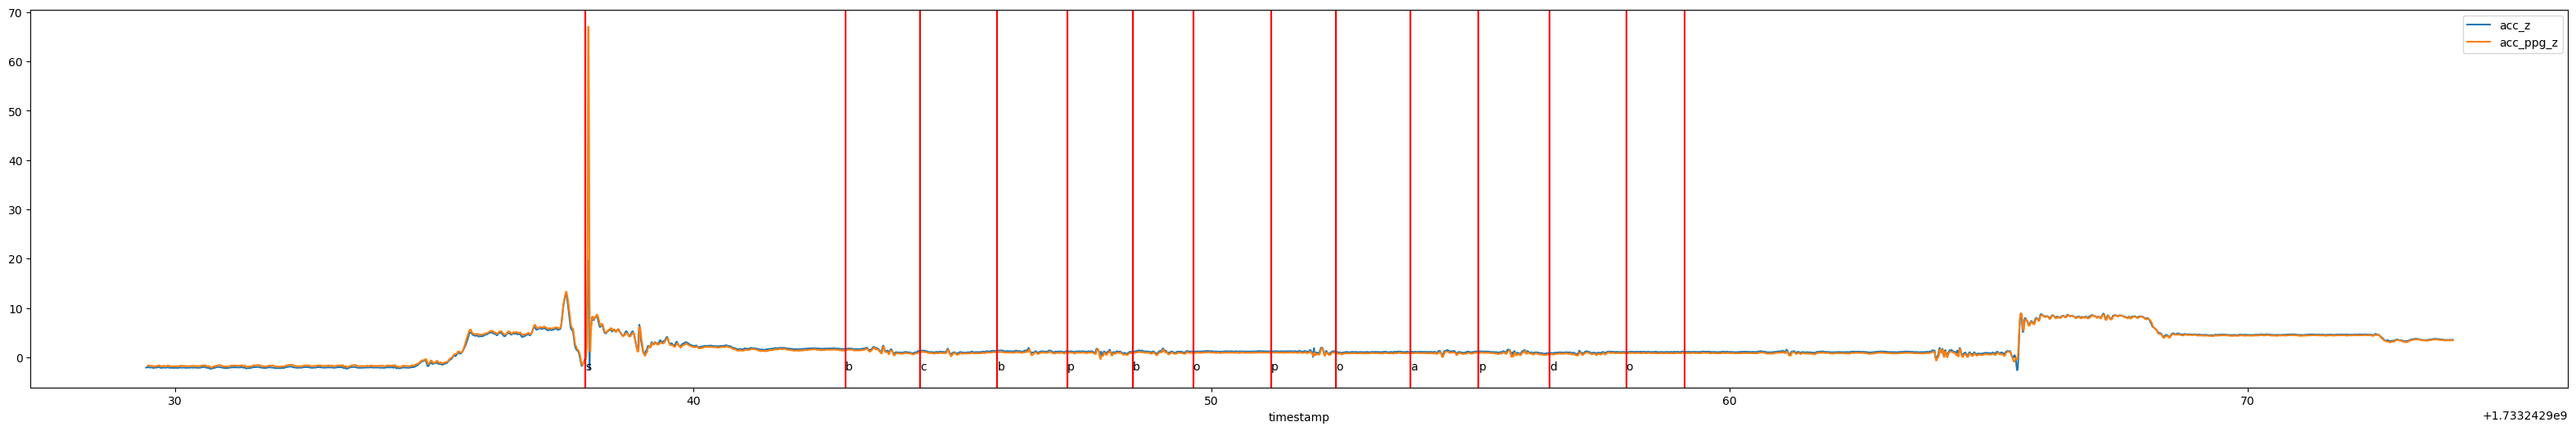

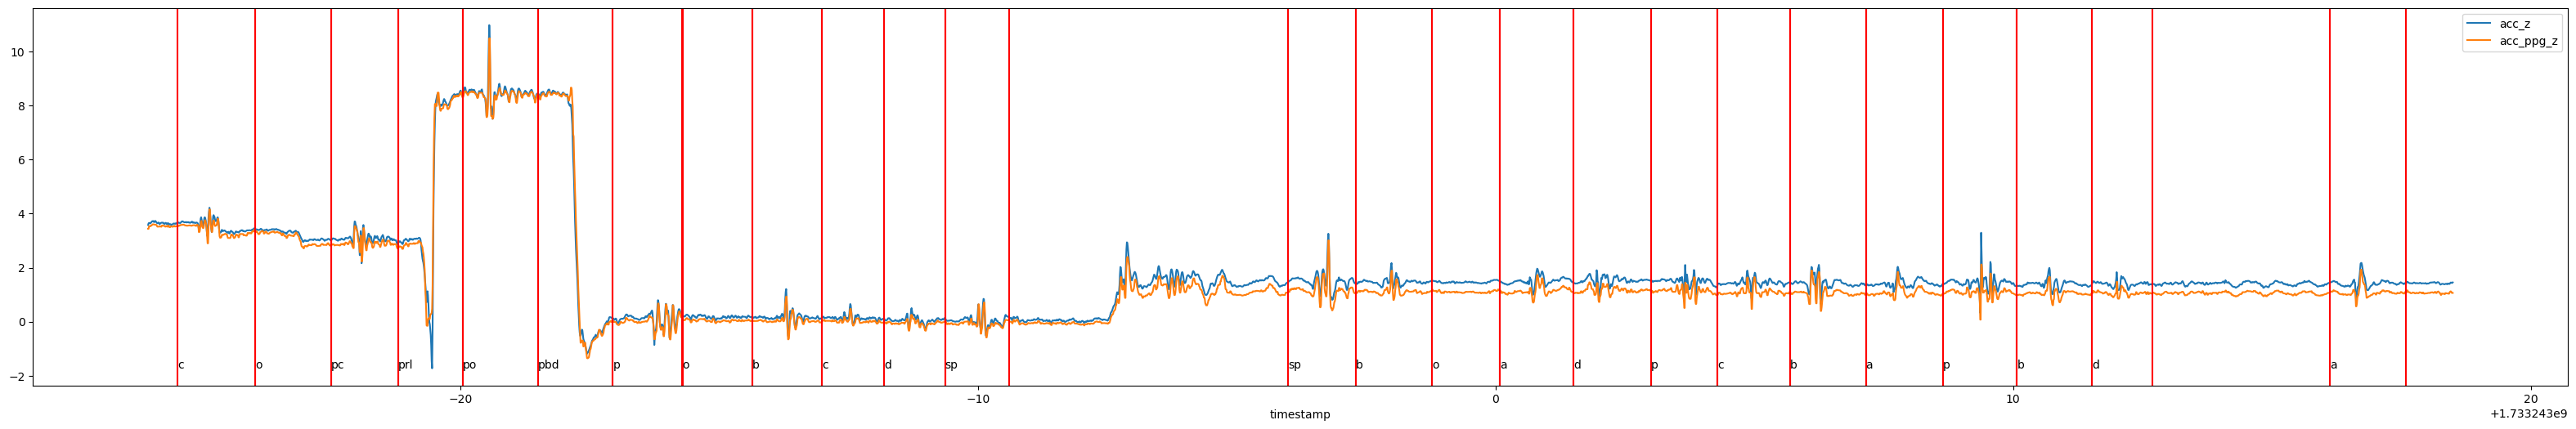

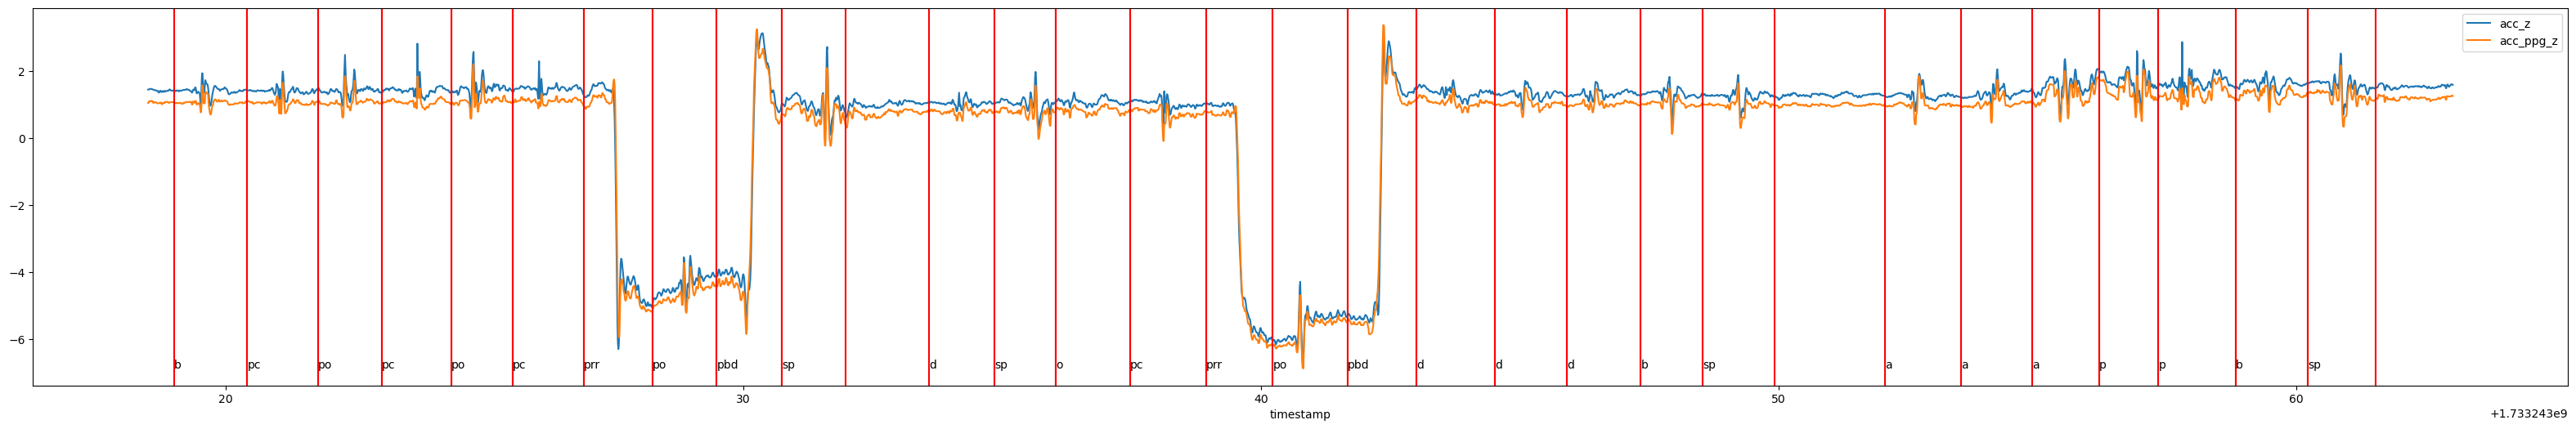

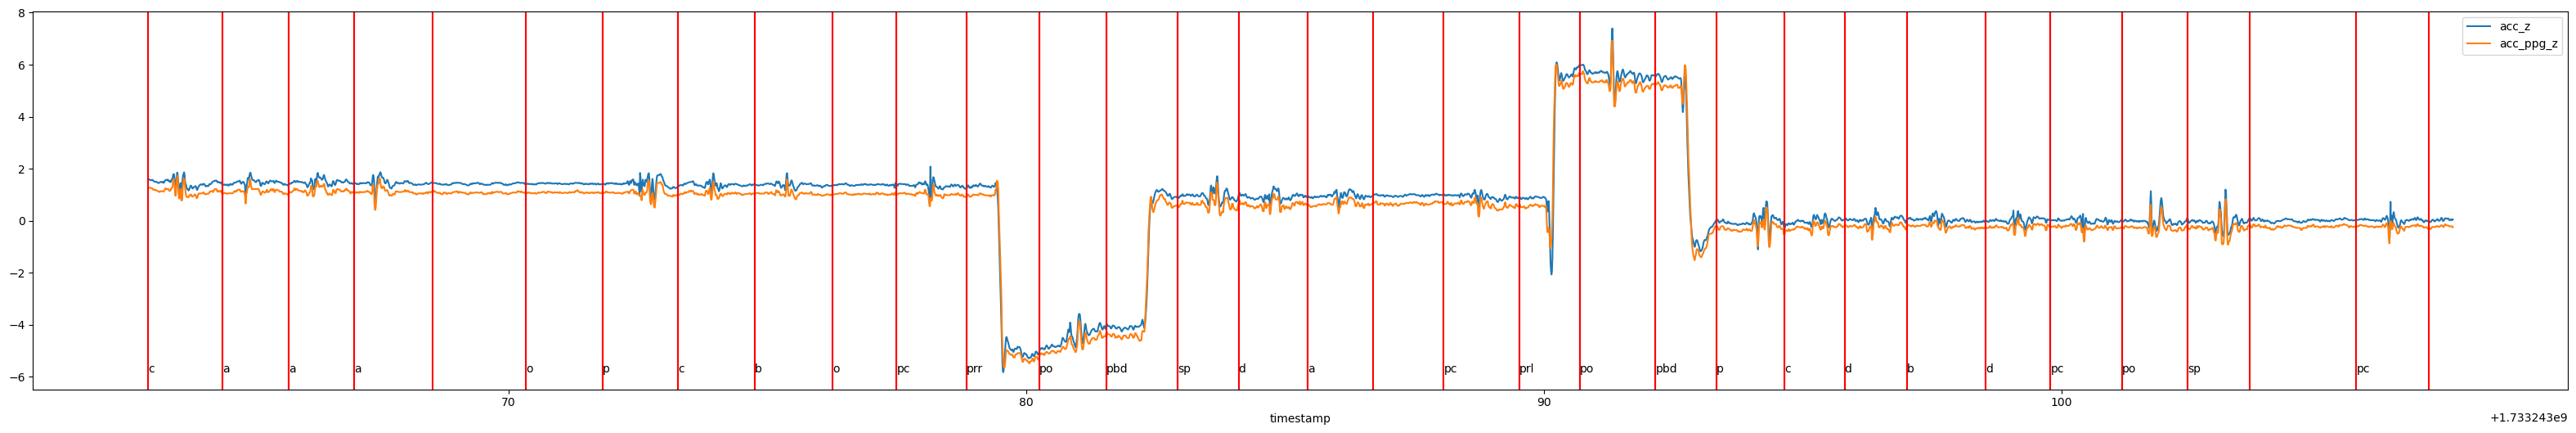

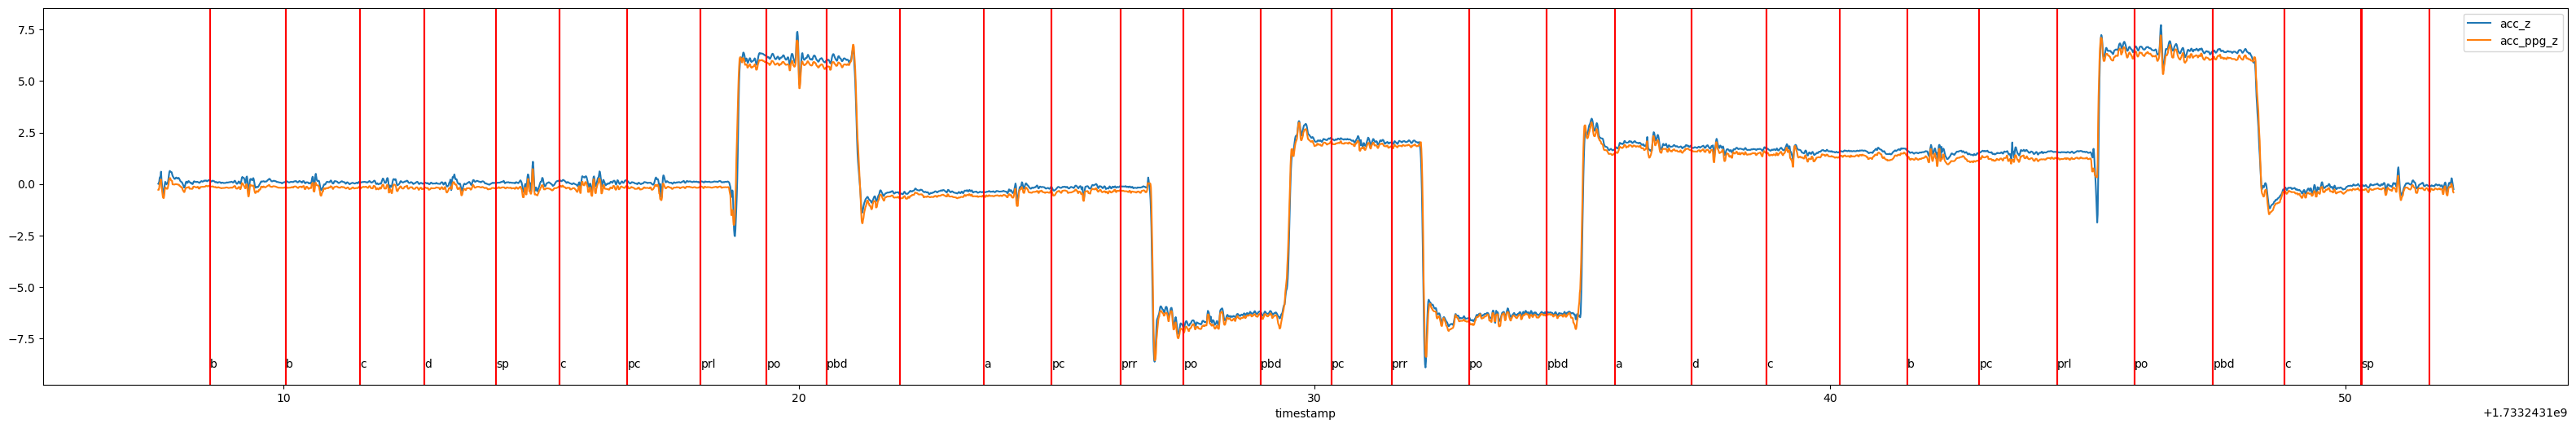

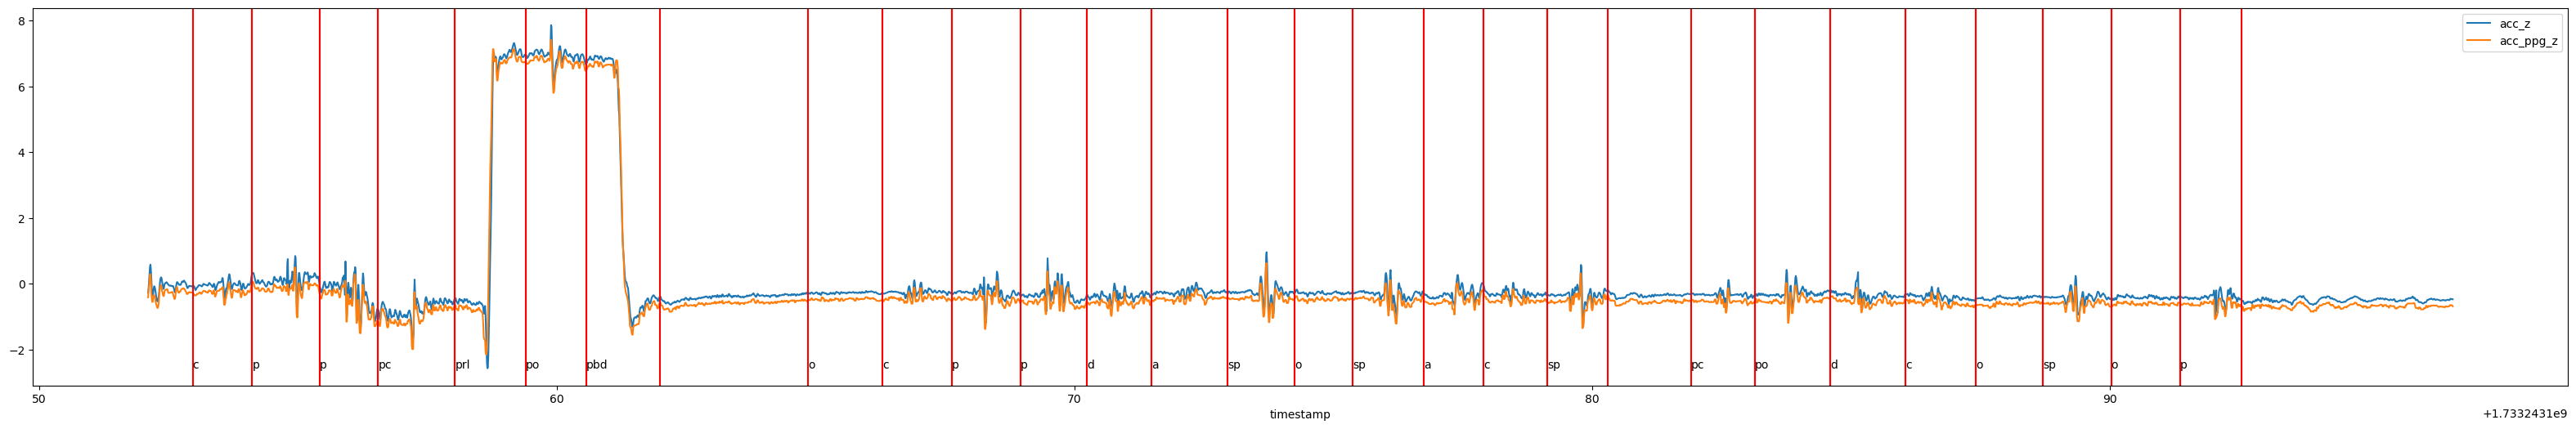

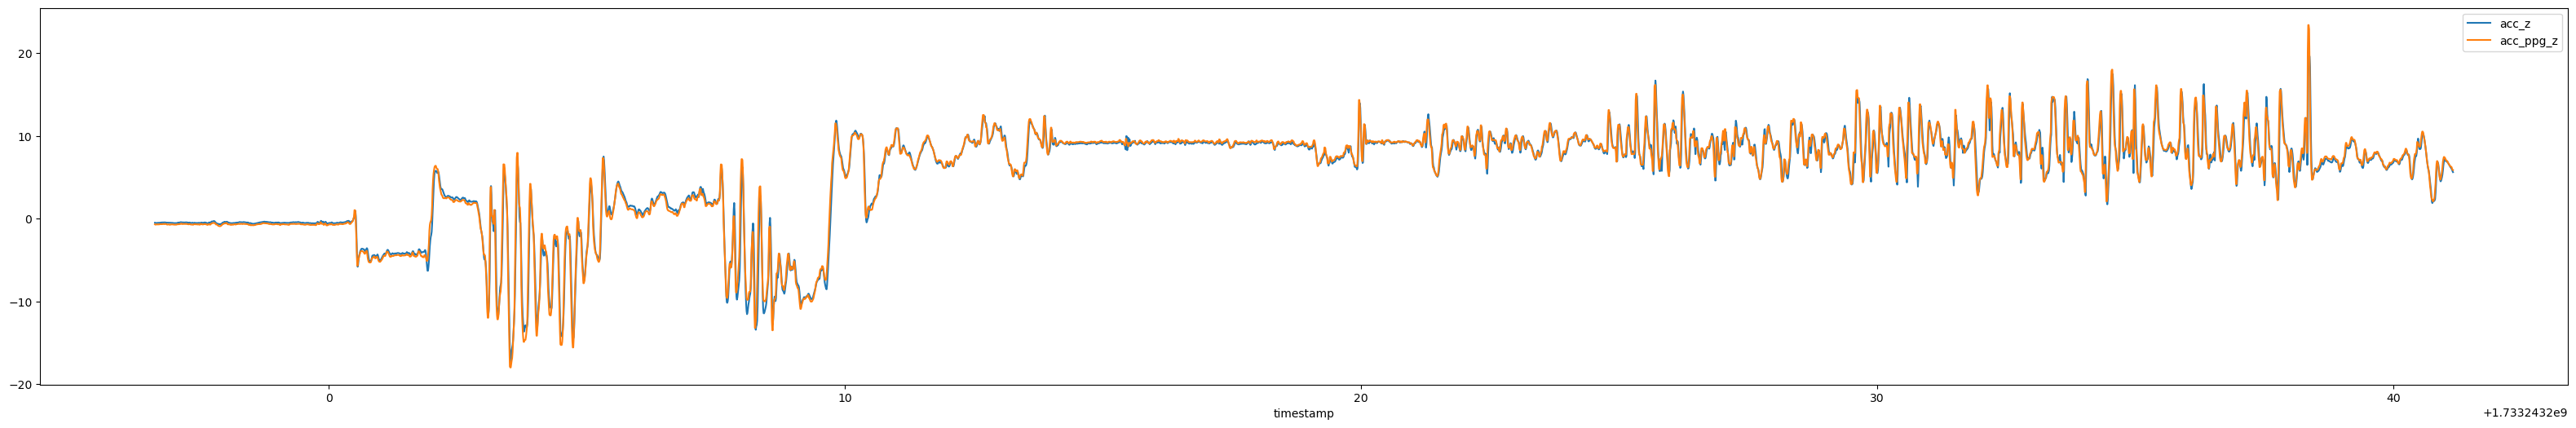

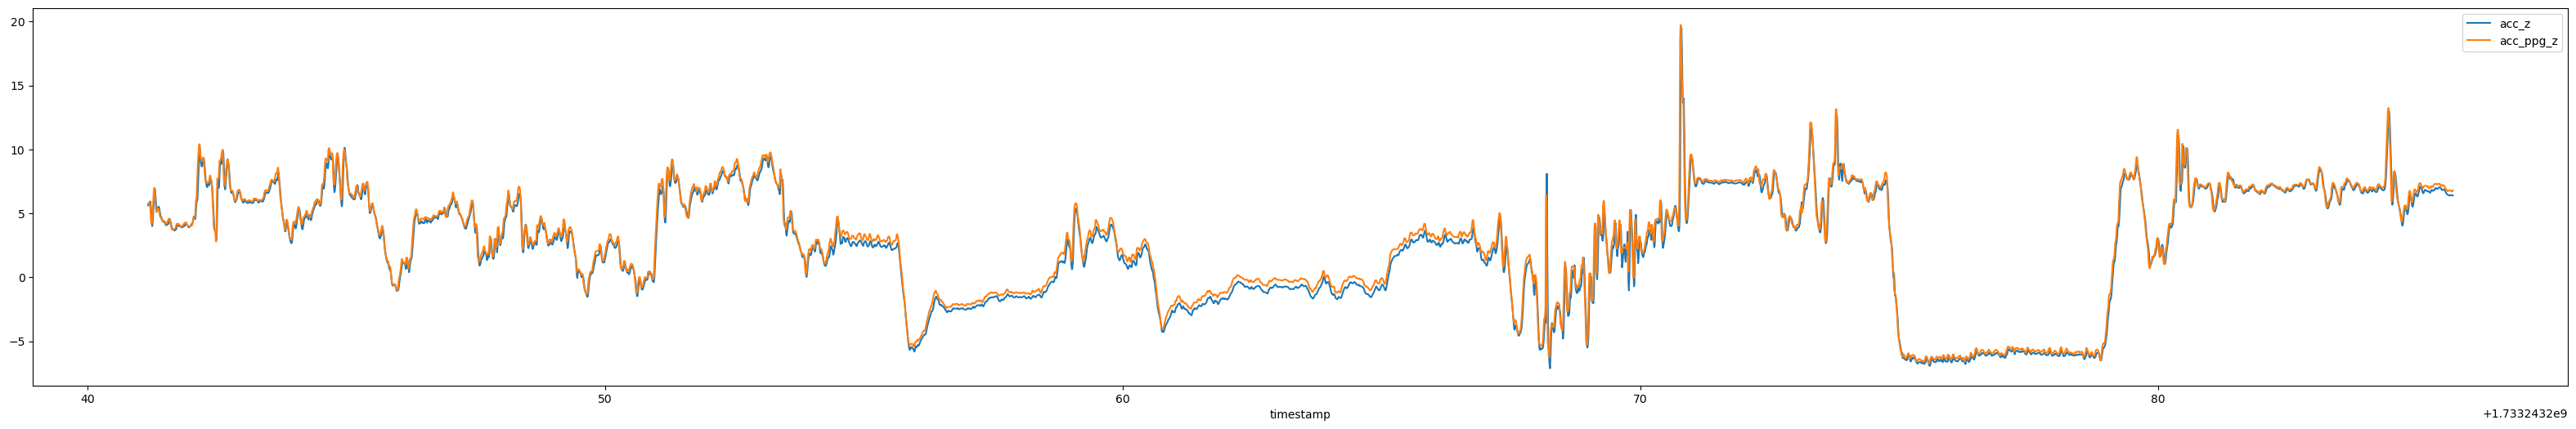

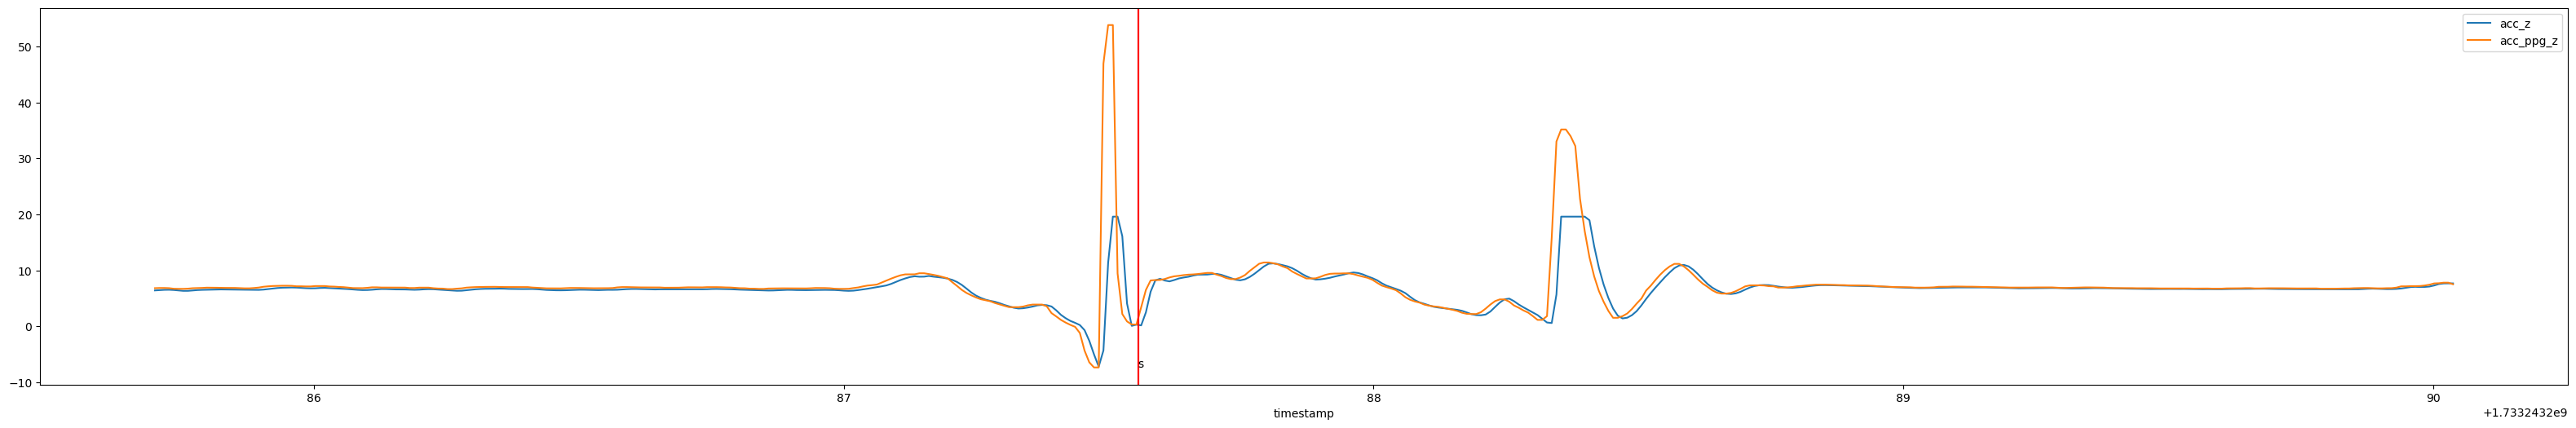

In [1042]:

def plot_with_labels(df ,labels):
    fig, ax = plt.subplots(figsize=(40, 6))
    df.plot(ax=ax)
    df_min = df.min().min() if isinstance(df, pd.DataFrame) else df.min()
    x_range = [df.index[0], df.index[-1]]
    for index, row in labels.iterrows():
        if row["start_time"] < x_range[0] or row["end_time"] > x_range[1]:
            continue
        ax.axvline(x=row["start_time"], color='r')
        ax.axvline(x=row["end_time"], color='r')
        ax.text(row["start_time"] , df_min, row["label"], rotation=0)
    return ax

plot_with_labels(df_all[["acc_z", "acc_ppg_z"]], labels_re)
for i in range(0, len(df_all), 5000):
    plot_with_labels(df_all[["acc_z", "acc_ppg_z"]].iloc[i:i+5000], labels_re)


        

<Axes: xlabel='timestamp'>

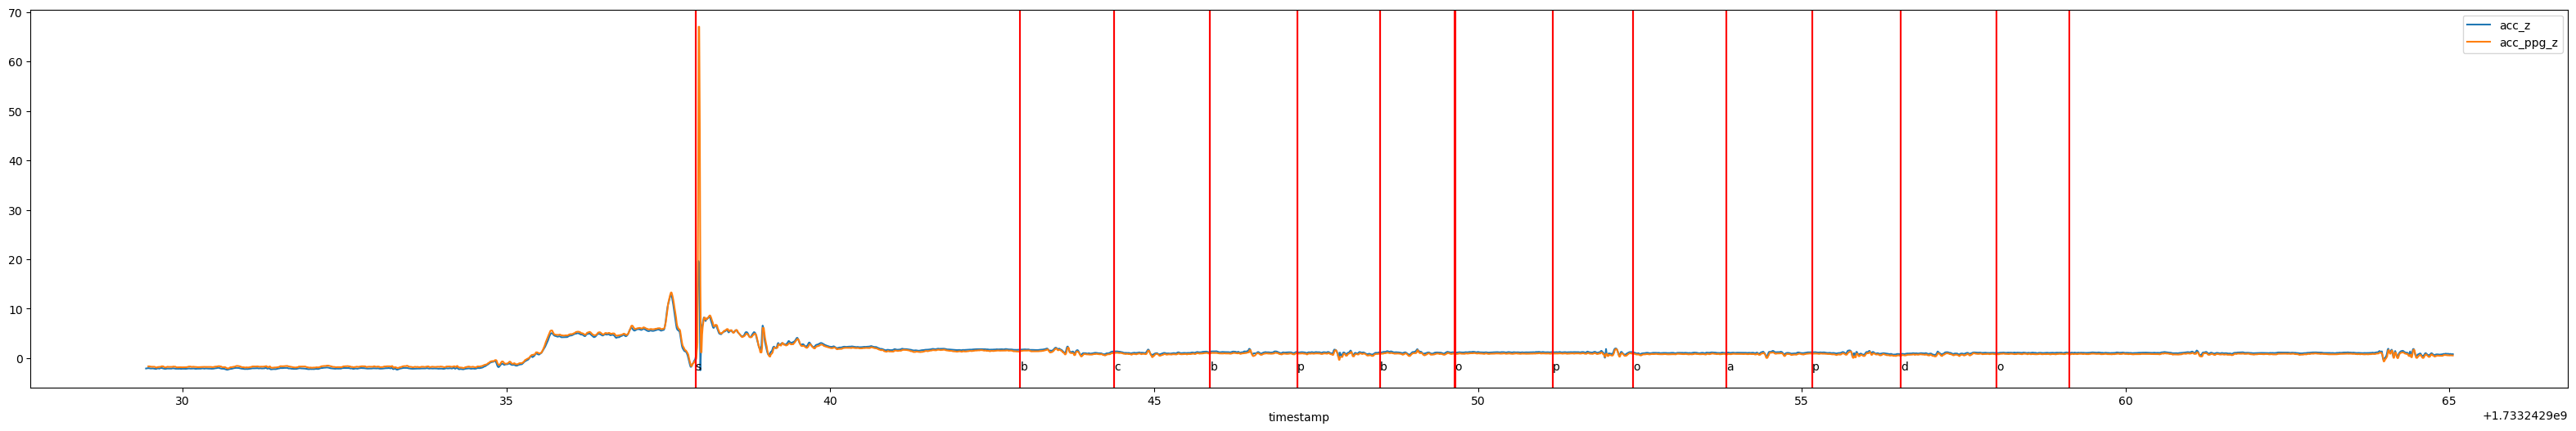

In [1043]:
plot_with_labels(df_all[["acc_z", "acc_ppg_z"]].iloc[0:4000], labels_re)

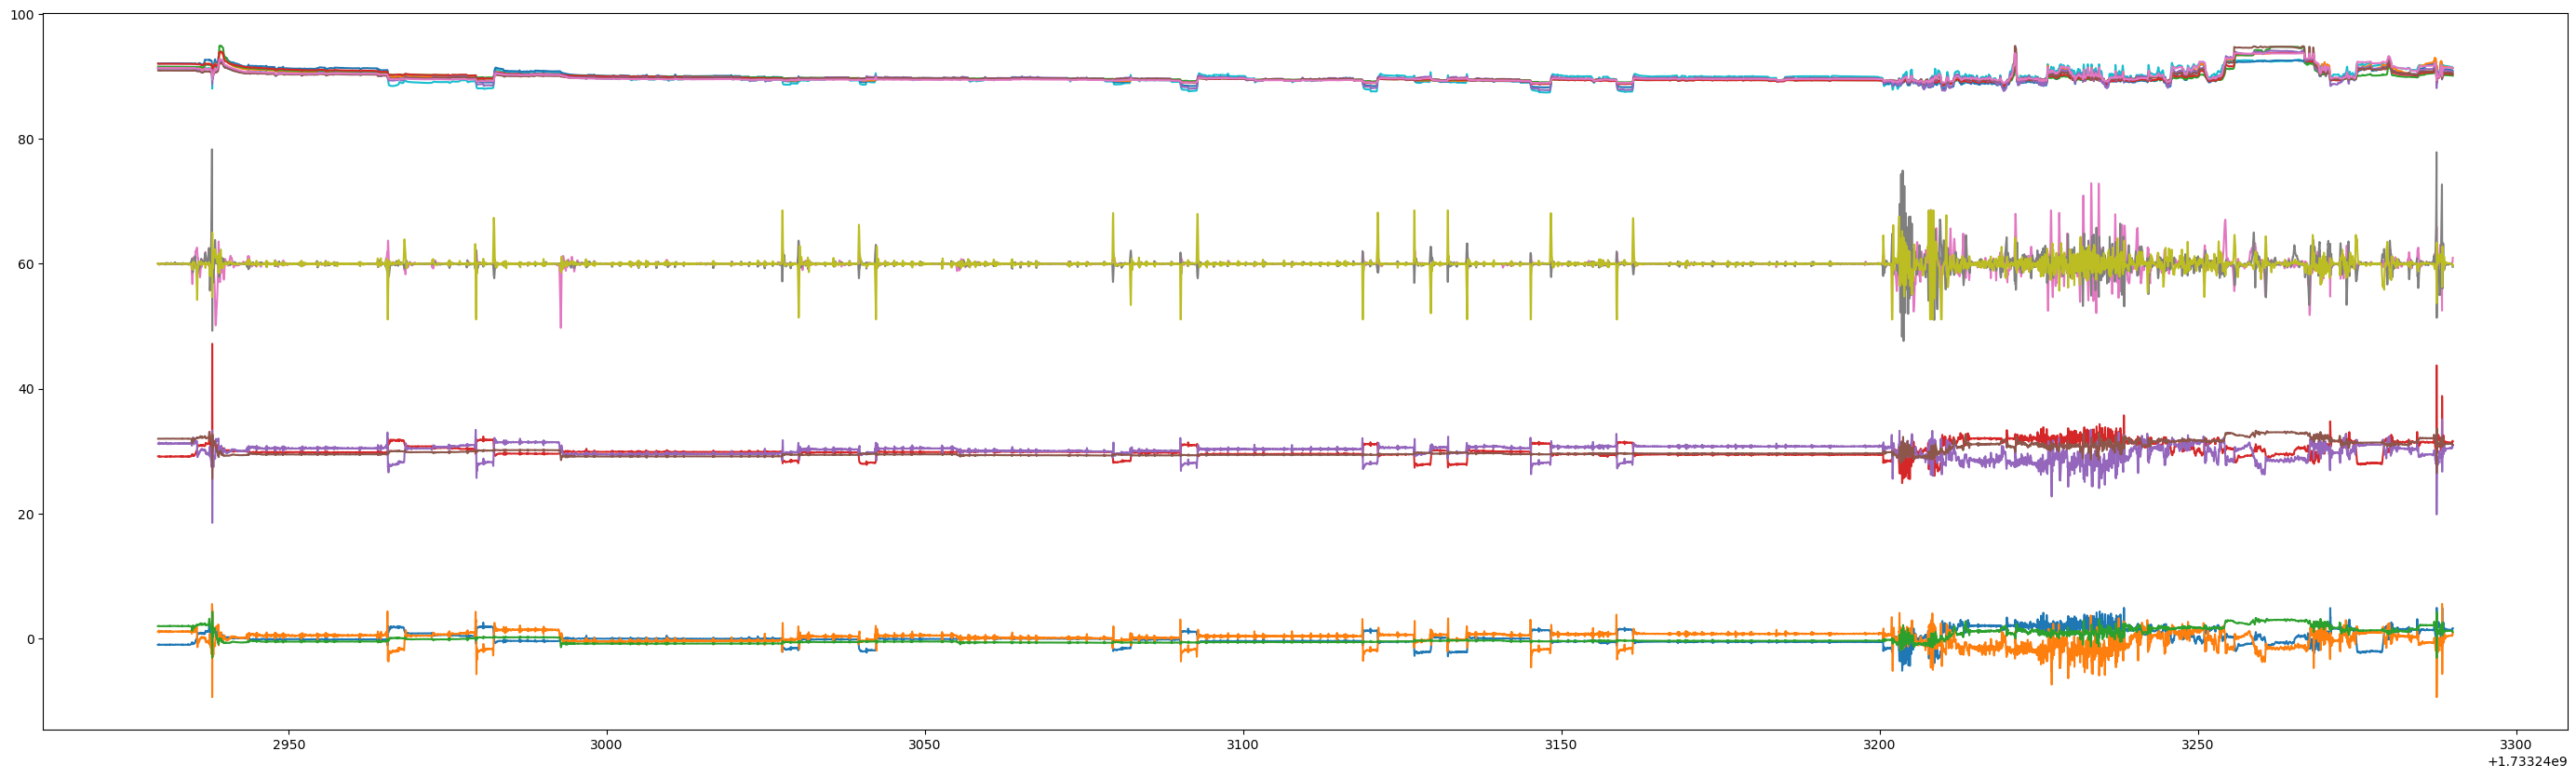

In [1044]:
def normalize_df(df):
    df_new = df.copy()
    for col in df_new.columns:
        df_new.loc[:,col] = (df_new[col] - df_new[col].mean()) / df_new[col].std()
    return df_new

fig, ax = plt.subplots(1, figsize=(35,10))
ax.plot(normalize_df(df_all[["acc_z", "acc_y", "acc_x"]]))
ax.plot(normalize_df(df_all[["acc_ppg_z", "acc_ppg_y", "acc_ppg_x"]]) + 30)
ax.plot(normalize_df(df_all[["gyro_z", "gyro_y", "gyro_x"]]) + 60)
ax.plot(normalize_df(df_all[["ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8"]]) + 90)

In [1045]:
labels_index = labels_re.copy()

for i, row in labels_re.iterrows():
    label_start = df_all.index[df_all.index > row["start_time"]]
    label_start = label_start[0] if len(label_start) > 0 else df_all.index[-1]
    labels_index.at[i, "start_index"] = df_all.index.get_loc(label_start)
    label_end = df_all.index[df_all.index > row["end_time"]]
    label_end = label_end[0] if len(label_end) > 0 else df_all.index[-1]
    labels_index.at[i, "end_index"] = df_all.index.get_loc(label_end)
    if label_end == label_start and labels_index.at[i, "label"] != "s":
        labels_index.drop(i, inplace=True)
labels_index[["start_index", "end_index"]] = labels_index[["start_index", "end_index"]].astype(int)


In [1046]:
label_neg = labels_index[(labels_index["label"] == "o") & ((labels_index["end_index"] - labels_index["start_index"]) > 300)].iloc[0]

window_size, step_size = 150, 50
time_window_size = window_size / sampling_rate_ppg
s_indices = np.arange(label_neg["start_index"], label_neg["end_index"] - window_size, step_size)
s_times = np.linspace(label_neg["start_time"], label_neg["end_time"] - time_window_size, len(s_indices))

additional_labels = {"start_time": [], "end_time": [],  "label": [], "start_index": [], "end_index": []}

for s_index, s_time in zip(s_indices, s_times):
    e_index = s_index + window_size
    e_time = s_time + time_window_size

    if e_index > len(df_all):
        print(e_index)
        continue

    additional_labels["start_time"].append(s_time)
    additional_labels["end_time"].append(s_time)
    additional_labels["start_index"].append(s_index)
    additional_labels["end_index"].append(e_index)
    additional_labels["label"].append("o")

labels_index = pd.concat([labels_index, pd.DataFrame(additional_labels)], ignore_index=True)
labels_index = labels_index.drop(label_neg.name)


In [1047]:
df_all.drop(columns=["package_id", "timestamp_computer"], inplace=True)
df_all.reset_index(inplace=True)

assert (labels_index["start_index"] > 0).all()
assert (labels_index["end_index"] < len(df_all)).all()

In [1048]:
drop_count = 0
for i, row in labels_index.iterrows():
    correlation_z = df_all.iloc[row["start_index"]:row["end_index"]][["acc_z", "acc_ppg_z"]].corr().iloc[0,1]
    correlation_x = df_all.iloc[row["start_index"]:row["end_index"]][["acc_x", "acc_ppg_x"]].corr().iloc[0,1]
    correlation_y = df_all.iloc[row["start_index"]:row["end_index"]][["acc_y", "acc_ppg_y"]].corr().iloc[0,1]
    correlation = np.mean([correlation_z, correlation_x, correlation_y])
    if correlation < 0.75:
        #print(f"Bad correlation for {i} with {correlation}")
        # remove that label
        #labels_index.drop(i, inplace=True)
        drop_count += 1

print(f"Dropped {drop_count}/{len(labels_re)} labels due to bad correlation")

Dropped 8/158 labels due to bad correlation


In [1049]:
""" 
def compute_energy(signals:np.array):
    return np.sum(signals**2, axis=1)

def smooth_signal(signal, window_size=10):
    from scipy.ndimage import gaussian_filter1d
    return gaussian_filter1d(signal, window_size/2)

def detect_peaks(signal):
    from scipy.signal import find_peaks, find_peaks_cwt
    peaks, _ = find_peaks(signal, distance=1, prominence=1.0)
    #peaks = find_peaks_cwt(signal, widths=np.arange(1, 10))
    return peaks

def plot_peaks(peaks, signal, start_index, end_index, ax):
    for peak in peaks:
        if peak < start_index or peak > end_index:
            continue
        ax.plot(peak - start_index, signal[peak], "x", color="red")
    return ax

signal_energy_gyro = compute_energy(df_all[["gyro_x", "gyro_y", "gyro_z"]].to_numpy()/16)
signal_energy_acc = compute_energy(df_all[["acc_x", "acc_y", "acc_z"]].to_numpy())

signal_energy_gyro = smooth_signal(signal_energy_gyro, window_size=10)
signal_energy_acc = smooth_signal(signal_energy_acc, window_size=10)

signal_energy = signal_energy_gyro + signal_energy_acc
signal_energy = np.abs(np.diff(signal_energy))*16
signal_energy_peaks = detect_peaks(signal_energy)



all_shifts = {}

prev_shift = 0
for i, row in labels_index.iterrows():
    #print(label_start, label_end)
    label_peaks = signal_energy_peaks[(signal_energy_peaks > row["start_index"]) & (signal_energy_peaks < row["end_index"])]
    
    if len(label_peaks) == 0 or labels_index.loc[i, "label"] in ["o", "pbd"]:
        shift = 0
    else:
        peaks_sizes = signal_energy[label_peaks]
        largest_peak = label_peaks[np.argmax(peaks_sizes)]
        shift = largest_peak - (label_start + label_end) / 2
        shift = min(max(shift, -40), 50)
    labels_index.loc[i, "start_index"] += (shift + prev_shift)/2
    labels_index.loc[i, "end_index"] += (shift + prev_shift)/2
    prev_shift = shift
    all_shifts[i] = shift
 """

' \ndef compute_energy(signals:np.array):\n    return np.sum(signals**2, axis=1)\n\ndef smooth_signal(signal, window_size=10):\n    from scipy.ndimage import gaussian_filter1d\n    return gaussian_filter1d(signal, window_size/2)\n\ndef detect_peaks(signal):\n    from scipy.signal import find_peaks, find_peaks_cwt\n    peaks, _ = find_peaks(signal, distance=1, prominence=1.0)\n    #peaks = find_peaks_cwt(signal, widths=np.arange(1, 10))\n    return peaks\n\ndef plot_peaks(peaks, signal, start_index, end_index, ax):\n    for peak in peaks:\n        if peak < start_index or peak > end_index:\n            continue\n        ax.plot(peak - start_index, signal[peak], "x", color="red")\n    return ax\n\nsignal_energy_gyro = compute_energy(df_all[["gyro_x", "gyro_y", "gyro_z"]].to_numpy()/16)\nsignal_energy_acc = compute_energy(df_all[["acc_x", "acc_y", "acc_z"]].to_numpy())\n\nsignal_energy_gyro = smooth_signal(signal_energy_gyro, window_size=10)\nsignal_energy_acc = smooth_signal(signal_energ

In [1050]:
import h5py

def save_to_hdf5(df_all, labels_df, output_file):
    # Read the labels from a CSV or pandas dataframe

    # Open an HDF5 file
    with h5py.File(output_file, 'w') as hdf5_file:
        # Iterate over each row of the dataframe
        for idx, row in labels_df.iterrows():
            label = row['label']
            start_index = row['start_index']
            end_index = row['end_index']
            start_time = row['start_time']
            end_time = row['end_time']

            # Create a group named 'Label_Timestamp' (label + index)
            group_name = f"{label}_{int(start_time*1000)}"
            label_group = hdf5_file.create_group(group_name)

            # Save the start and end indexes as datasets in the group
            label_group.create_dataset('start_index', data=start_index)
            label_group.create_dataset('end_index', data=end_index)
            label_group.create_dataset('label', data=label)
            label_group.create_dataset('start_time', data=start_time)
            label_group.create_dataset('end_time', data=end_time)
        
        data_group = hdf5_file.create_group("data")
        for column in df_all.columns:
            data_group.create_dataset(column, data=df_all[column].values)

            

    print(f"Labels saved to {output_file}")
    

save_path = os.path.join(save_dir, "participant_"+ participant_name.split("_")[0], f"participant_{participant_name}.hdf5")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_to_hdf5(df_all, labels_index, save_path)

Labels saved to C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_miyuki\participant_miyuki_4.hdf5
